# Grounding Dino test 

## Install all the dependencies

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from typing import List
from PIL import Image
from skimage import measure
import cv2

import torch
import transformers
import accelerate

import os
import sys
import torch
from diffusers import StableDiffusionInpaintPipeline
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device is: CUDA") if torch.cuda.is_available else print("Device is: CPU")


/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Device is: CUDA


In [3]:
import platform
import sys
import subprocess

# Check Operating System
os_info = platform.platform()

# Check Python Version
python_version = sys.version

# Check CUDA Version
try:
    cuda_version = subprocess.check_output(['nvcc', '--version']).decode('utf-8')
except FileNotFoundError:
    cuda_version = "nvcc not found - CUDA might not be installed."

# Check System Architecture
architecture = platform.machine()

# Check PyTorch Version
try:
    import torch
    pytorch_version = torch.__version__
except ImportError:
    pytorch_version = "PyTorch not installed."

# Print all the information
print(f"Operating System: {os_info}")
print(f"Python Version: {python_version}")
print(f"CUDA Version: {cuda_version}")
print(f"System Architecture: {architecture}")
print(f"PyTorch Version: {pytorch_version}")


Operating System: Linux-5.4.0-169-generic-x86_64-with-glibc2.35
Python Version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
CUDA Version: nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0

System Architecture: x86_64
PyTorch Version: 2.1.1+cu121


In [4]:
!nvidia-smi

Sat Jun 22 21:43:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               On  | 00000000:53:00.0 Off |                  Off |
| 30%   30C    P8              19W / 230W |      5MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Download the model and their respective weights

Set the configuration and weights for DINO

In [5]:
GROUNDING_DINO_CONFIG_PATH = "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
print(
    GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH)
)

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join("weights", "groundingdino_swint_ogc.pth")
print(
    GROUNDING_DINO_CHECKPOINT_PATH,
    "; exist:",
    os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH),
)

GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
weights/groundingdino_swint_ogc.pth ; exist: True


In [6]:

from GroundingDINO.groundingdino.util.inference import (
    load_model,
    load_image,
    predict,
    annotate,
    Model,
)

grounding_dino_model = Model(
    model_config_path=GROUNDING_DINO_CONFIG_PATH,
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH,
)



final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Load the model

## Create a Class of groundingDINO



In [7]:
import cv2
import matplotlib.pyplot as plt
from groundingdino.util.inference import Model  # Adjust import based on your actual structure

class GroundingDINO:
    def __init__(self, model):
        self.model = model
        self.BOX_THRESHOLD = 0.35
        self.TEXT_THRESHOLD = 0.25
    
    def predict_with_captions(self, image, text_prompt):
        # Assuming self.model.predict_with_caption returns detections and phrases
        detections, phrases = self.model.predict_with_caption(
            image=image,
            caption=text_prompt,
            box_threshold=self.BOX_THRESHOLD,
            text_threshold=self.TEXT_THRESHOLD,
        )
        return detections, phrases
    
    def visualize_detections(self, image, detections):
        # Visualize detections as before
        image_with_boxes = image.copy()
        for i, box in enumerate(detections.xyxy):
            x_min, y_min, x_max, y_max = map(int, box)
            class_id = detections.data[i]['class_id']
            cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image_with_boxes, class_id, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_with_boxes_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.title('Original Image')
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.imshow(image_with_boxes_rgb)
        plt.title('Image with Detections')
        plt.axis('off')
        plt.show()



# SAM segmentation test

## SAM Class

In [8]:
class SAMSegmenter:
    def __init__(self, checkpoint_path, model_type='vit_h', device='cuda'):
        self.checkpoint_path = checkpoint_path
        self.model_type = model_type
        self.device = device
        
        # Instantiate SAM model
        self.sam_model = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device=device)
        
        # Instantiate SAM predictor and mask generator
        self.sam_predictor = SamPredictor(self.sam_model)
        self.mask_generator = SamAutomaticMaskGenerator(self.sam_model)
    
    def segment(self, image, xyxy):
        self.sam_predictor.set_image(image)
        result_masks = []
        for box in xyxy:
            masks, scores, logits = self.sam_predictor.predict(box=box, multimask_output=True)
            index = np.argmax(scores)
            result_masks.append(masks[index])
        return np.array(result_masks)
    
    def make_sam_mask(self, boolean_mask):
        binary_mask = boolean_mask.astype(int)
        contours = measure.find_contours(binary_mask, 0.5)
        mask_points = []
        for contour in contours:
            contour = np.flip(contour, axis=1)
            segmentation = contour.ravel().tolist()
            mask_points.append(segmentation)
        return mask_points
    
    def make_annotations(self, detections):
        if len(detections.xyxy) == 0:
            return None

        annotations = [{"name": f"image id: {detections.tracker_id}", "data": []}]

        for i in range(len(detections.xyxy)):
            annotations[0]["data"].append({
                "label": detections.data[i],
                "score": round((detections.confidence[i] * 100), 2),
                "points": self.make_sam_mask(detections.mask[i]),
            })

        return annotations



## Stable diffusion Class

In [9]:
class StableDiffusionInpainter:
    def __init__(self, pretrained_model_path, torch_dtype=torch.float16, device='cuda'):
        self.device = device
        self.pipe = StableDiffusionInpaintPipeline.from_pretrained(
            pretrained_model_path,
            torch_dtype=torch_dtype,
        ).to(device)
        
    def generate_image(self, image, mask, prompt, negative_prompt, seed):
        # Resize for inpainting
        w, h = image.size
        in_image = image.resize((512, 512))
        in_mask = mask.resize((512, 512))

        generator = torch.Generator(device=self.device).manual_seed(seed)

        result = self.pipe(
            image=in_image,
            mask_image=in_mask,
            prompt=prompt,
            negative_prompt=negative_prompt,
            generator=generator,
        )
        result = result.images[0]

        return result.resize((w, h))
        
# Initialize StableDiffusionInpainter
STABLE_DIFFUSION_MODEL_PATH = "stabilityai/stable-diffusion-2-inpainting"
sd_inpainter = StableDiffusionInpainter(STABLE_DIFFUSION_MODEL_PATH, torch_dtype=torch.float16, device='cuda')



model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
def load_grounding_dino_model(config_path, checkpoint_path):
    grounding_dino_model = Model(
        model_config_path=config_path,
        model_checkpoint_path=checkpoint_path,
    )
    return grounding_dino_model

def process_image_with_grounding_dino(grounding_dino, image, text_prompt):
    detections, phrases = grounding_dino.predict_with_captions(image, text_prompt)
    for i, phrase in enumerate(phrases):
        detections.data[i] = {'class_id': phrase}
    return detections

def plot_images_grid(images, original_image, titles, grid_size, size, cmap="gray"):
    nrows, ncols = grid_size

    if len(images) > nrows * ncols:
        raise ValueError("The number of images exceeds the grid size.")

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=size)
    for idx in range(len(images)):
        row_idx = idx // ncols
        col_idx = idx % ncols
        ax = axes[row_idx, col_idx]
        
        blended_image = blend_image_and_mask(original_image, images[idx])
        ax.imshow(blended_image)
        
        if titles is not None and idx < len(titles):
            ax.set_title(titles[idx])
        
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

def plot_images_grid(images, original_image, titles, grid_size, size, cmap="gray"):
    nrows, ncols = grid_size

    if len(images) > nrows * ncols:
        raise ValueError("The number of images exceeds the grid size.")

    if nrows == 1 and ncols == 1:
        fig, ax = plt.subplots(figsize=size)
        blended_image = blend_image_and_mask(original_image, images[0])
        ax.imshow(blended_image)
        if titles is not None:
            ax.set_title(titles[0])
        ax.axis("off")
    else:
        raise ValueError("The number of images exceeds 1.")

    plt.tight_layout()
    plt.show()


def blend_image_and_mask(image, mask):
    """
    Blend the original image and mask.
    :param image: Original image (RGB)
    :param mask: Binary mask
    :return: Blended image
    """
    # Convert original image to RGBA format
    image_rgba = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)

    mask_rgba = np.zeros((*image.shape[:-1], 4), dtype=np.uint8)
    mask_rgba[:, :, 2] = mask * 100  # Dark blue channel for mask
    mask_rgba[:, :, 3] = mask * 128  # Alpha channel for mask
   
    # Blend images
    blended = cv2.addWeighted(image_rgba, 1.0, mask_rgba, 0.7, 0)

    # Convert blended image back to RGB format
    blended_rgb = cv2.cvtColor(blended, cv2.COLOR_RGBA2RGB)

    return blended_rgb


final text_encoder_type: bert-base-uncased


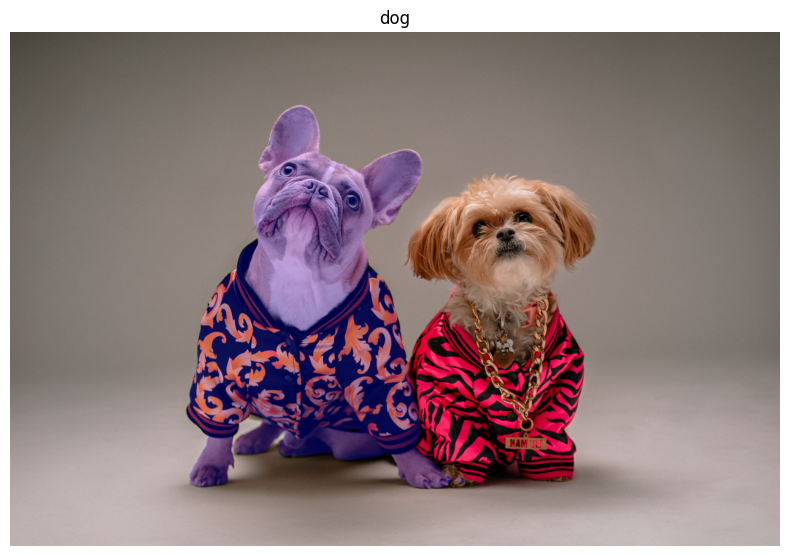

  0%|          | 0/50 [00:00<?, ?it/s]

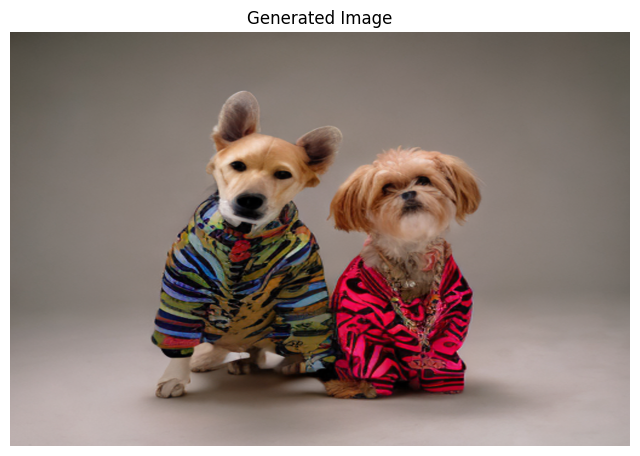

In [14]:
if __name__ == "__main__":
    torch.cuda.empty_cache()
    # Paths and constants
    GROUNDING_DINO_CONFIG_PATH = GROUNDING_DINO_CONFIG_PATH
    GROUNDING_DINO_CHECKPOINT_PATH = GROUNDING_DINO_CHECKPOINT_PATH
    SAM_CHECKPOINT_PATH = "weights/sam_vit_h_4b8939.pth"
    
    IMAGE_PATH = '/workspace/images/dogs.jpg'

    
    # Enter the text PROMPT
    TEXT_PROMPT = "left dog".strip().lower()
    PAIN_PROMPT = "a Golden Retriber".strip().lower()
    # Load GroundingDINO model
    grounding_dino_model = load_grounding_dino_model(GROUNDING_DINO_CONFIG_PATH, GROUNDING_DINO_CHECKPOINT_PATH)
    grounding_dino = GroundingDINO(grounding_dino_model)

    # Load image
    image_bgr = cv2.imread(IMAGE_PATH)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    # Process image with GroundingDINO
    detections = process_image_with_grounding_dino(grounding_dino, image_bgr, TEXT_PROMPT)

#     # Visualize detections
#     grounding_dino.visualize_detections(image_bgr, detections)

    # Instantiate SAMSegmenter
    sam_segmenter = SAMSegmenter(checkpoint_path=SAM_CHECKPOINT_PATH, model_type='vit_h', device='cuda')

    # Segment using SAM
    detections.mask = sam_segmenter.segment(image=image_bgr, xyxy=detections.xyxy)

    # Make annotations
    annotations = sam_segmenter.make_annotations(detections)
    
    # Prepare flor plotting
    titles = []
    for i in range(len(detections.mask)):
        titles.append(detections.data[i]['class_id'])

    # Plot images with masks overlaid
    plot_images_grid(
        images=[detections.mask[0]],
        original_image=image_rgb,
        titles= titles,
        grid_size=(1, 1),
        size=(8, 8),
    )
    if TEXT_PROMPT == 'background':
        # Prepare inputs for inpainting
        mask = detections.mask[0]
        # Generate outpainted image 
        image_source_pil = Image.fromarray(image_rgb)
        image_mask_pil = Image.fromarray(mask)

        p_negative_prompt = "low resolution, ugly"
        p_SEED = 32
        generated_image = sd_inpainter.generate_image(
            image=image_source_pil,
            mask=image_mask_pil,
            prompt=PAIN_PROMPT,
            negative_prompt=p_negative_prompt,
            seed=p_SEED,
        )
        generated_image
        # Display generated image
        plt.figure(figsize=(8, 8))
        plt.imshow(generated_image)
        plt.title('Generated Image')
        plt.axis('off')
        plt.show()
    else: 
        
        # Prepare inputs for inpainting
        mask = detections.mask[0]

        image_source_pil = Image.fromarray(image_rgb)
        image_mask_pil = Image.fromarray(mask)

        p_negative_prompt = "low resolution, ugly"
        p_SEED = 6

        # Generate inpainted image
        generated_image = sd_inpainter.generate_image(
            image=image_source_pil,
            mask=image_mask_pil,
            prompt=PAIN_PROMPT,
            negative_prompt=p_negative_prompt,
            seed=p_SEED,
        )

        # Display generated image
        plt.figure(figsize=(8, 8))
        plt.imshow(generated_image)
        plt.title('Generated Image')
        plt.axis('off')
        plt.show()